<a href="https://colab.research.google.com/github/PawelMlyniec/social-media-buzz/blob/main/PPD_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biblioteki i wczytywanie danych

Używane biblioteki:

In [ ]:
#%load_ext tensorboard

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import scipy  as sp
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import Ridge, ElasticNet
from scipy.stats import norm
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

import tensorflow as tf
from tensorflow import keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
!pip install tensorflow-addons
import tensorflow_addons as tfa
from datetime import datetime

import xgboost as xgb

Wczytywanie danych

In [ ]:
# #Read from drive
# #trzeba stworzć folder PPD na swoim dysku googla i wrzucić tam dane
from google.colab import drive
drive.mount('/content/drive')
#working read from drive
data = pd.read_csv('/content/drive/My Drive/PPD/socialmediabuzz.csv', header=None) 
x = data.iloc[:, :-2].values
y = data.iloc[:,-2].values

In [ ]:
#alternative: read from session storage
data = pd.read_csv('socialmediabuzz.csv')
clean_x = data.iloc[:, :-2].values
y = data.iloc[:,-2].values
data.iloc[:, -2].describe()

count    140706.000000
mean        193.233572
std         653.167506
min           0.000000
25%           2.000000
50%          19.000000
75%         130.500000
max       75724.500000
Name: 932.5, dtype: float64

Wczytywanie danych jako seria

In [ ]:
serialized_x = np.array([row.reshape(11, 7).T for row in x])

# Funkcje do ewaluacji danych

In [ ]:
def create_and_fit_ridge_model(x,y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, random_state=512)
  model = Ridge(max_iter=1000000)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
  print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
  print(f"R^2: {metrics.r2_score(y_test, y_pred)}") 

  return y_pred, y_test

In [ ]:
def create_and_fit_elasticnet_model(x,y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, random_state=512)
  model = ElasticNet(max_iter=1000000)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
  print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
  print(f"R^2: {metrics.r2_score(y_test, y_pred)}")
  return y_pred, y_test

In [ ]:
def create_network_model(x, y ,hparams):
  n_cols = x.shape[1]

  model = Sequential()
  for _ in range(hparams[HP_LAYERS]):   
    model.add(tf.keras.layers.Dense(hparams[HP_NEURONS], activation=hparams[HP_ACTIVATION]))
  model.add(Dense(1, activation='linear'))

  model.compile( 
      optimizer=hparams[HP_OPTIMIZER], 
      loss=hparams[HP_LOSS],
      metrics=['mean_squared_error','mean_absolute_error', tf.keras.metrics.RootMeanSquaredError(),tfa.metrics.RSquare()])
  return model

def fit_model(model, x, y, x_test, y_test, hparams, logdir):
  #logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

  hist = model.fit(
      x=x,
      y=y,
      batch_size=hparams[HP_BATCH_SIZE],
      epochs = hparams[HP_EPOCHS],
      validation_data=(x_test, y_test),
      verbose=0,
      callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
      ])
  
  y_pred =  model.predict(x_test)

  print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
  print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
  print(f"R^2: {metrics.r2_score(y_test, y_pred)}")

In [ ]:
def create_reccurent_net_model(hparams):
  model = tf.keras.Sequential()
  if hparams[HP_LAYERS] == 1:
    model.add( tf.compat.v1.keras.layers.CuDNNGRU(100, input_shape=(7, 11)))
  else:
    model.add( tf.compat.v1.keras.layers.CuDNNGRU(100,return_sequences=True, input_shape=(7, 11)))
    for _ in range(hparams[HP_LAYERS] - 2):
      model.add( tf.compat.v1.keras.layers.CuDNNGRU(100, return_sequences=True,))
    model.add( tf.compat.v1.keras.layers.CuDNNGRU(100))

  model.add( tf.keras.layers.Dense(1))
  model.compile( 
      optimizer=hparams[HP_OPTIMIZER],
       loss=hparams[HP_LOSS],
       metrics=['mean_squared_error','mean_absolute_error', 'root_mean_squared_error'])
  print(model.summary())

  return model

def fit_recurrent_net_model(model, serialized_x, y, hparams, logdir):
  x_train, x_test, y_train, y_test = train_test_split(serialized_x, y, test_size = .1, random_state=76)

  hist = model.fit(
      x=x_train,
      y=y_train,
      batch_size=hparams[HP_BATCH_SIZE],
      epochs = hparams[HP_EPOCHS],
      validation_data=(x_test, y_test),
      verbose=0,
      callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
      ])
  
  y_pred =  model.predict(x_test)

  print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
  print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
  print(f"R^2: {metrics.r2_score(y_test, y_pred)}")

In [ ]:
def fit_xgboost_model(x, y, learning_rate = 0.2, colsample_bytree = 0.3, max_depth = 10, alpha = 5, n_estimators = 20):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, random_state=512)

  xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = colsample_bytree, learning_rate = learning_rate,
    max_depth = max_depth, alpha = alpha, n_estimators = n_estimators)
  xg_reg.fit(x_train, y_train)

  y_pred = xg_reg.predict(x_test)
  rmse = math.sqrt(metrics.mean_squared_error(y_test, y_pred))
  mae = metrics.mean_absolute_error(y_test, y_pred)
  r2 = metrics.r2_score(y_test, y_pred)
  return np.asarray([rmse, mae, r2])

# Wykład 1

Standaryzacja

In [ ]:
scaler = StandardScaler()
std_x = scaler.fit_transform(x)

Macierz kowariancji

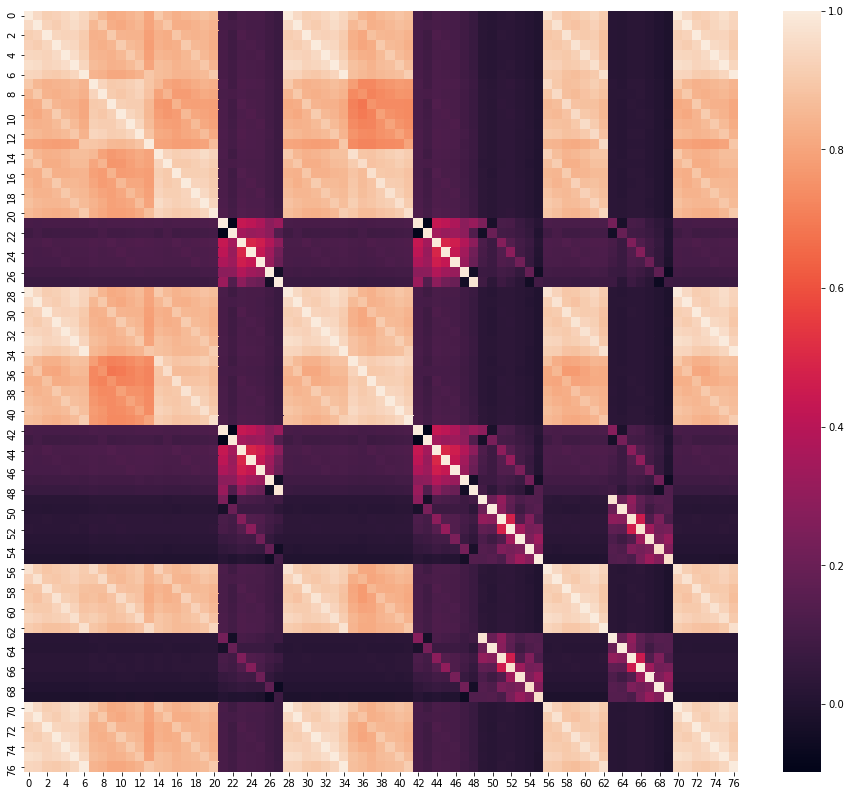

In [ ]:
df_x = pd.DataFrame(data=std_x)
plt.figure(figsize=(16,14))
sns.heatmap(df_x.cov())

# Wykład 2

Redukcja wymiarowości: opcja 1: PCA

In [ ]:
pca = PCA(n_components = 13)
components = pca.fit_transform(std_x)
print(pca.explained_variance_)
pca_x = components

[43.39826795  6.44375779  3.76785474  2.60824412  2.23089682  2.1396185
  1.78814498  1.61360073  1.5651602   1.3333086   1.25503064  1.14492801
  1.05957824]


Macierz kowariancji

In [ ]:
df_pca = pd.DataFrame(data=pca_x)
plt.figure(figsize=(16,14))
sns.heatmap(df_pca.cov())

Redukcja wymiarowości: opcja 2: Analiza czynnikowa

In [ ]:
fa = FactorAnalyzer(n_factors=13, rotation=None)
fa.fit(std_x)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print(ev)
fa_x = fa.transform(std_x)

[4.33979595e+01 6.44371199e+00 3.76782797e+00 2.60822558e+00
 2.23088096e+00 2.13960329e+00 1.78813227e+00 1.61358926e+00
 1.56514909e+00 1.33329912e+00 1.25502174e+00 1.14491988e+00
 1.05957074e+00 9.43618357e-01 9.26365877e-01 7.56054999e-01
 6.71841736e-01 6.40742171e-01 5.28672629e-01 4.45867896e-01
 3.22934265e-01 3.06557000e-01 2.13329120e-01 1.69030543e-01
 1.05171809e-01 6.83584571e-02 5.42250846e-02 5.24829639e-02
 3.69749273e-02 3.26689175e-02 2.95937186e-02 2.90934758e-02
 2.72702359e-02 2.65772453e-02 2.34642184e-02 2.17347479e-02
 1.94992373e-02 1.86113877e-02 1.72417073e-02 1.63260495e-02
 1.55745138e-02 1.38206150e-02 1.17414693e-02 1.09147259e-02
 1.04193738e-02 9.57580697e-03 9.23523548e-03 8.25335736e-03
 7.23763301e-03 6.44439813e-03 6.34666090e-03 5.69895755e-03
 5.27630578e-03 4.78322460e-03 3.93265564e-03 2.82289925e-03
 2.50673249e-03 2.35519547e-03 2.04776065e-03 1.60313585e-03
 1.23959312e-03 1.08119726e-03 9.67330495e-04 8.95157061e-04
 8.57907368e-04 6.945200

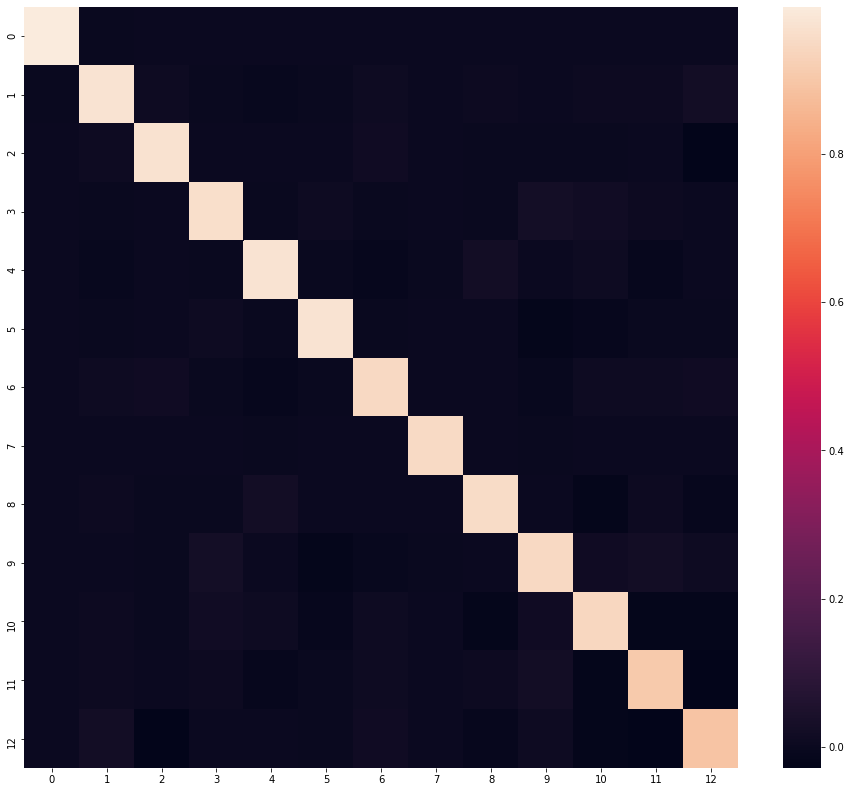

In [ ]:
df_fa = pd.DataFrame(data=fa_x)
plt.figure(figsize=(16,14))
sns.heatmap(df_fa.cov())

# Wykład 3


Kryterium Chauveneta

In [ ]:
def chauvenet(x: np.ndarray) -> np.ndarray:
  sum_mask = np.full(x.shape[0], False)
  for column in x.T:
    d = np.abs(column-np.mean(column))/np.std(column)
    propability = len(column) * norm.pdf(d)    
    mask = propability < 0.5 
    sum_mask = np.logical_or(sum_mask, mask)
  
  return np.where(sum_mask == True)[0]

### clean solution

In [ ]:
delete_idices = chauvenet(x)
outlined_x = x[delete_idices,]
outlined_y = y[delete_idices,]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, random_state=512)
delete_idices = chauvenet(x_train)
deleted_x = np.delete(x_train, delete_idices, axis=0)
deleted_y = np.delete(y_train, delete_idices, axis=0)

for performance

In [ ]:
model = create_network_model(x,y)
fit_model(model, x, y)
model = create_network_model(deleted_x, deleted_y)
fit_model(model, deleted_x, deleted_y)

#### y's plots

In [ ]:
pd.DataFrame(y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

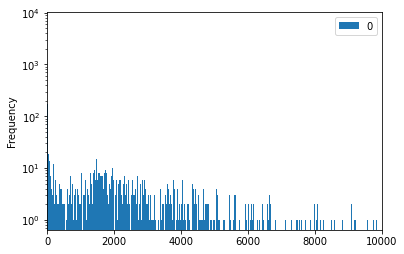

In [ ]:
pd.DataFrame(outlined_y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

#### y's desc

In [ ]:
print(pd.DataFrame(y).describe())
print(pd.DataFrame(outlined_y).describe())

                   0
count  140707.000000
mean      193.238826
std       653.168158
min         0.000000
25%         2.000000
50%        19.000000
75%       130.500000
max     75724.500000
                  0
count   9445.000000
mean     804.314187
std     2152.481411
min        0.000000
25%        0.000000
50%        1.500000
75%      363.500000
max    75724.500000


#### x's desc

In [ ]:
print("x:")
pd.DataFrame(x).describe()

x:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
count,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000,140707.000000
mean,172.279823,155.150625,165.464476,176.820549,186.937700,216.209208,243.866510,87.050154,78.639236,84.269574,90.533776,95.749586,110.877220,127.185151,0.000234,0.000216,0.000229,0.000238,0.000247,0.000282,0.000312,0.901194,0.909363,0.871815,0.884976,0.889780,0.928793,0.954723,184.758917,166.175009,177.293873,189.790572,200.511744,232.455848,262.280022,0.000132,0.000122,0.000129,0.000134,0.000139,0.000159,0.000176,0.906941,0.914119,0.876374,0.889551,0.894376,0.933557,0.959853,1.013431,1.012180,0.972701,0.988940,0.997408,1.051740,1.113331,150.697954,135.643827,144.482172,154.597980,163.167191,188.259021,211.743446,1.057531,1.050505,1.016524,1.035727,1.045443,1.113444,1.196131,172.838807,155.630878,165.938674,177.314810,187.463794,216.776294,244.479194
std,509.872276,471.573236,495.360236,528.351277,560.331281,632.188378,707.402192,234.731748,218.448179,233.536510,249.845958,262.817528,295.239382,341.975099,0.000633,0.000601,0.000632,0.000644,0.000663,0.000734,0.000782,0.291636,0.281184,0.329292,0.313744,0.307715,0.250447,0.199043,537.031810,494.981401,520.755784,556.859009,589.662660,664.051316,740.395188,0.000384,0.000374,0.000387,0.000386,0.000397,0.000440,0.000470,0.290516,0.280189,0.329155,0.313450,0.307357,0.249056,0.196305,1.124253,1.308200,1.252893,1.124353,1.420541,1.243509,1.648966,417.125467,383.102986,407.662030,436.316037,457.801715,512.349128,571.069849,1.236017,1.404408,1.344194,1.226276,1.520631,1.374287,1.826150,510.937549,472.462733,496.233557,529.286514,561.309487,633.203935,708.436795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,4.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,0.000004,0.000003,0.000004,0.000004,0.000004,0.000006,0.000008,0.996764,0.998896,0.995812,0.996687,0.996815,0.999248,1.000000,3.000000,2.000000,3.000000,3.000000,3.000000,5.000000,6.000000,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000004,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [ ]:
print("outlined x:")
pd.DataFrame(outlined_x).describe()

outlined x:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
count,9445.00000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000,9445.000000
mean,701.91244,646.480889,678.371202,727.919534,777.378825,880.607835,974.998094,316.658338,292.249444,310.354367,336.144415,359.293171,402.666808,450.909794,0.000889,0.000844,0.000885,0.000900,0.000932,0.001034,0.001084,0.641459,0.814287,0.615107,0.705455,0.729663,0.964451,0.393900,738.988777,679.117205,712.724087,767.160296,819.398729,929.001694,1027.395977,0.000525,0.000505,0.000529,0.000531,0.000548,0.000608,0.000642,0.653785,0.823716,0.624563,0.714346,0.737745,0.976707,0.401906,1.179294,1.316121,1.070437,1.191077,1.249969,1.596603,1.124513,579.701853,530.824669,559.094230,603.430492,641.968237,724.099206,796.460879,1.277231,1.393541,1.164244,1.314299,1.365362,1.802194,1.321322,703.463420,647.802012,679.672419,729.296983,778.879936,882.205188,976.724299
std,1608.38083,1500.640058,1564.747481,1668.505144,1776.324041,2002.886821,2259.290901,706.258627,667.132441,710.682867,756.999585,795.593356,886.649328,1045.957114,0.001912,0.001843,0.001928,0.001943,0.001996,0.002192,0.002310,0.474842,0.384800,0.482962,0.451555,0.440305,0.172913,0.484987,1683.554496,1563.415341,1634.622279,1748.196323,1859.186627,2090.155080,2348.756330,0.001208,0.001197,0.001226,0.001203,0.001237,0.001363,0.001447,0.475788,0.381082,0.484261,0.451749,0.439884,0.150840,0.490309,4.101082,4.844028,4.595814,4.081277,5.274189,4.558734,6.215785,1275.740550,1180.518754,1254.936001,1343.478424,1408.699166,1568.809354,1765.958149,4.448327,5.154519,4.864574,4.387067,5.571841,4.939207,6.721543,1611.288633,1502.984973,1567.084802,1671.066370,1778.995584,2005.650216,2262.103621
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.994427,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.

### PCA

In [ ]:
delete_idices = chauvenet(pca_x)
outlined_x = pca_x[delete_idices,]
outlined_y = y[delete_idices,]

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(pca_x, y, test_size = .1, random_state=512)
delete_idices = chauvenet(x_train_pca)
deleted_x_pca = np.delete(x_train_pca, delete_idices, axis=0)
deleted_y_pca = np.delete(y_train_pca, delete_idices, axis=0)

#### y's plot

In [ ]:
pd.DataFrame(y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

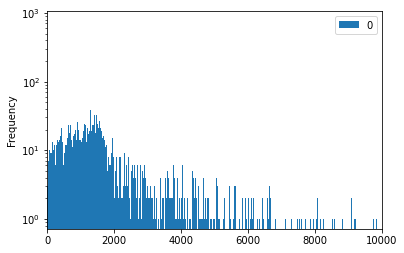

In [ ]:
pd.DataFrame(outlined_y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

#### y's desc

In [ ]:
print(pd.DataFrame(y).describe())
print(pd.DataFrame(outlined_y).describe())

                   0
count  140707.000000
mean      193.238826
std       653.168158
min         0.000000
25%         2.000000
50%        19.000000
75%       130.500000
max     75724.500000
                  0
count   6388.000000
mean    1695.407170
std     2367.155579
min        0.000000
25%      559.500000
50%     1254.500000
75%     1873.000000
max    75724.500000


#### x' desc

In [ ]:
print("x:")
pd.DataFrame(pca_x).describe()

x:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05,1.407070e+05
mean,-3.088638e-13,-1.944009e-13,4.608572e-14,4.189317e-14,-5.998844e-14,1.190703e-14,1.053914e-13,3.455197e-14,-1.196682e-14,-1.951142e-13,1.015457e-13,2.026971e-14,1.519461e-14,1.591900e-14,2.653788e-14,2.014538e-14,-1.077467e-14,-1.267794e-13,-9.680979e-16,-7.616608e-14,1.200550e-13,2.194581e-13,-8.321713e-14,1.619832e-13
std,2.866313e+03,4.289780e+02,3.416009e+02,3.057273e+02,2.841225e+02,2.291103e+02,2.097540e+02,2.031915e+02,1.384622e+02,7.421810e+01,6.416097e+01,4.954261e+01,4.531640e+01,3.932169e+01,3.531825e+01,2.987929e+01,2.811476e+01,2.313550e+01,2.115503e+01,2.085885e+01,1.895082e+01,1.715089e+01,1.650504e+01,1.576150e+01
min,-1.026742e+03,-1.636441e+04,-2.185627e+04,-1.176225e+04,-1.513363e+04,-1.192421e+04,-7.495839e+03,-9.784885e+03,-5.489400e+03,-2.348779e+03,-3.068955e+03,-2.328698e+03,-2.494134e+03,-1.940191e+03,-1.848337e+03,-1.184977e+03,-9.324575e+02,-5.551148e+02,-1.014008e+03,-6.998824e+02,-5.133182e+02,-8.278890e+02,-6.281543e+02,-6.605459e+02
25%,-1.005041e+03,-2.640277e+01,7.974797e-01,-2.467108e+01,-1.109159e+01,-1.054886e+01,-1.530360e+01,-1.045858e+01,-2.515933e+00,-8.164080e+00,-1.310651e+00,-2.179472e+00,-2.293449e+00,-2.447525e+00,-2.180203e+00,-2.075642e+00,-1.397626e+00,-1.756572e+00,-1.579477e+00,-1.665522e+00,-1.295426e+00,-1.226699e+00,-1.179691e+00,-7.814319e-01
50%,-8.815363e+02,-1.243682e+01,3.696198e+01,-1.695178e+01,2.834613e+00,-1.466395e+00,-6.108470e+00,-6.863691e-02,9.190452e-01,-6.448139e+00,1.942757e+00,-5.024553e-02,3.325831e-01,-2.949035e-01,2.732746e-02,-1.762939e-01,2.949398e-01,-4.829460e-01,-1.755041e-01,-6.717901e-01,-6.909079e-02,-3.621876e-02,5.363600e-03,2.875318e-01
75%,-2.016201e+02,5.909508e+00,4.332494e+01,2.046121e+00,1.162805e+01,9.579882e+00,3.777807e+00,9.067877e+00,7.290481e+00,-1.974842e+00,4.676255e+00,2.832614e+00,2.650939e+00,2.148387e+00,1.991792e+00,1.700229e+00,1.839679e+00,1.068812e+00,1.136467e+00,9.534360e-01,1.083312e+00,1.155264e+00,1.147245e+00,1.079902e+00
max,1.406026e+05,3.438380e+04,2.717484e+04,1.669106e+04,1.627113e+04,1.965451e+04,1.204554e+04,1.604538e+04,8.367282e+03,3.999028e+03,3.898944e+03,6.019026e+03,2.496601e+03,1.963320e+03,2.310866e+03,1.977329e+03,1.115027e+03,1.290450e+03,1.308984e+03,1.225634e+03,6.404869e+02,8.465288e+02,7.010935e+02,9.283039e+02


In [ ]:
print("outlined x:")
pd.DataFrame(outlined_x).describe()

outlined x:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000
mean,7795.820612,78.715949,-110.686233,90.795049,35.294649,12.952588,68.935785,4.168749,-42.650483,53.565391,-22.997005,-10.197104,-3.294881,1.580753,2.147423,2.867094,-4.141959,2.187491,1.429953,6.025853,0.375935,0.902700,1.527673,-2.490724
std,9110.805118,1778.961809,1466.101583,1274.588315,1198.404345,954.190042,860.282454,835.103716,579.544918,295.220441,267.732721,211.965591,190.842812,164.791167,148.523886,124.575023,115.976569,95.435959,87.375370,85.865031,78.374702,69.799279,67.280265,64.375882
min,-908.238682,-16364.413535,-21856.266965,-11762.254831,-15133.631688,-11924.209842,-7495.839043,-9784.885125,-5489.400248,-2348.779208,-3068.954672,-2328.697751,-2494.134129,-1940.191187,-1848.337007,-1184.976674,-932.457468,-555.114850,-1014.008178,-699.882368,-513.318217,-827.888985,-628.154285,-660.545925
25%,2989.417610,-609.205274,-686.006238,-461.875574,-463.075302,-356.637060,-333.233378,-390.570045,-250.777958,-83.946567,-124.529540,-94.970033,-84.017637,-67.639004,-56.749063,-48.192480,-53.023280,-46.109337,-39.947644,-33.009577,-38.590425,-34.163120,-31.027725,-30.715423
50%,5282.150949,-38.076837,-157.464899,55.927512,23.467645,38.084920,-16.614220,-16.329988,-42.351145,20.433257,-20.596294,-3.639201,-1.280720,3.671781,-0.728434,1.414787,-0.005323,-3.444477,4.373858,7.105760,-2.732447,-0.671129,2.314486,-3.270994
75%,8818.306994,590.137993,304.149947,702.448193,522.755560,401.463071,402.995664,370.771533,184.044774,171.487740,81.625768,76.809636,79.881643,68.990448,56.150025,50.639938,50.282223,42.739955,45.548901,45.611116,32.065942,34.930774,33.338675,24.991722
max,140602.590780,34383.800553,27174.840233,16691.055916,16271.129217,19654.507809,12045.535405,16045.379983,8367.282259,3999.027725,3898.944431,6019.026277,2496.600814,1963.319651,2310.866351,1977.328932,1115.026878,1290.450359,1308.983691,1225.634331,640.486877,846.528752,701.093482,928.303948


### standarized

In [ ]:
delete_idices = chauvenet(std_x)
outlined_x = std_x[delete_idices,]
outlined_y = y[delete_idices,]

x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(std_x, y, test_size = .1, random_state=512)
delete_idices = chauvenet(x_train_std)
deleted_x_std = np.delete(x_train_std, delete_idices, axis=0)
deleted_y_std = np.delete(y_train_std, delete_idices, axis=0)

#### y's plot

In [ ]:
pd.DataFrame(y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

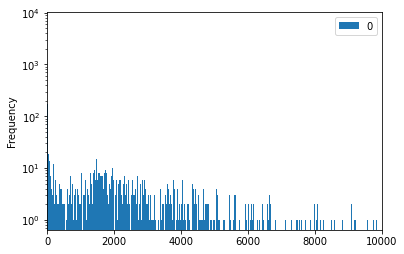

In [ ]:
pd.DataFrame(outlined_y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

#### y's desc

In [ ]:
print(pd.DataFrame(y).describe())
print(pd.DataFrame(outlined_y).describe())

                   0
count  140707.000000
mean      193.238826
std       653.168158
min         0.000000
25%         2.000000
50%        19.000000
75%       130.500000
max     75724.500000
                  0
count   9445.000000
mean     804.314187
std     2152.481411
min        0.000000
25%        0.000000
50%        1.500000
75%      363.500000
max    75724.500000


#### X's desc

In [ ]:
delete_idices = chauvenet(x)
deleted_x = np.delete(x, delete_idices, axis=0)
deleted_y = np.delete(y, delete_idices, axis=0)

In [ ]:
model = create_network_model(x,y)
fit_model(model, x, y)
model = create_network_model(deleted_x, deleted_y)
fit_model(model, deleted_x, deleted_y)

In [ ]:
delete_idices = chauvenet(pca_x)
deleted_x = np.delete(pca_x, delete_idices, axis=0)
deleted_y = np.delete(y, delete_idices, axis=0)

In [ ]:
model = create_network_model(pca_x,y)
fit_model(model, pca_x, y)
model = create_network_model(deleted_x, deleted_y)
fit_model(model, deleted_x, deleted_y)

### Wpływ usunięcia danych odstających na wynik sieci neuronowych

In [ ]:
HP_NEURONS = hp.HParam('neurons', hp.Discrete([32,128]))
HP_LAYERS = hp.HParam('layers', hp.Discrete([2,4,8]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['sigmoid','relu']))
HP_LOSS = hp.HParam('loss', hp.Discrete(['mse']))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([8,32]))
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([50]))
HP_DATA = hp.HParam('data_type', hp.Discrete(['clean', 'clean_chauvenet', 'pca', 'pca_chauvenet', 'std', 'std_chauvenet']))

# Data splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .1, random_state=512)
data_values = [
               (x_train,y_train, x_test,y_test), 
               (deleted_x, deleted_y, x_test ,y_test), 
               (x_train_pca, y_train_pca, x_test_pca, y_test_pca), 
               (deleted_x_pca, deleted_y_pca, x_test_pca, y_test_pca), 
               (x_train_std, y_train_std, x_test_std, y_test_std), 
               (deleted_x_std, deleted_y_std, x_test_std, y_test_std)]

METRIC = 'mean_squared_error'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NEURONS, HP_LAYERS, HP_OPTIMIZER, HP_ACTIVATION, HP_LOSS, HP_BATCH_SIZE, HP_DATA],
    metrics=[hp.Metric(METRIC, display_name='mean_squared_error')],
  )

session_num = 0
for neurons in HP_NEURONS.domain.values:
  for layers in HP_LAYERS.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      for activation in HP_ACTIVATION.domain.values:
        for loss in HP_LOSS.domain.values:
          for batch_size in HP_BATCH_SIZE.domain.values:
            for epochs in HP_EPOCHS.domain.values:
              for data_type, data_value in zip(HP_DATA.domain.values, data_values):
                hparams = {
                    HP_NEURONS: neurons,
                    HP_LAYERS: layers,
                    HP_OPTIMIZER: optimizer,
                    HP_ACTIVATION: activation,
                    HP_LOSS: loss,
                    HP_BATCH_SIZE: batch_size,
                    HP_DATA: data_type,
                    HP_EPOCHS: epochs
                    }

                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                model = create_network_model(x=data_value[0], y=data_value[1], hparams=hparams)
                
                fit_model( 
                    model=model,
                    logdir='logs/hparam_tuning3/' + run_name,
                    hparams=hparams, 
                    x=data_value[0], 
                    y=data_value[1], 

                    x_test=data_value[2],
                    y_test=data_value[3]
                    )
                session_num += 1

In [ ]:
!rm -rf ./logs/
%tensorboard --logdir logs/hparam_tuning

<IPython.core.display.Javascript object>

#### Wpływ danych odstających na wynik bez PCA// DELETE?

In [ ]:
delete_idices = chauvenet(x)
outlined_x = x[delete_idices,]
outlined_y = y[delete_idices,]
print(pd.DataFrame(y).describe())
print(pd.DataFrame(outlined_y).describe())

                   0
count  140707.000000
mean      193.238826
std       653.168158
min         0.000000
25%         2.000000
50%        19.000000
75%       130.500000
max     75724.500000
                  0
count   9445.000000
mean     804.314187
std     2152.481411
min        0.000000
25%        0.000000
50%        1.500000
75%      363.500000
max    75724.500000


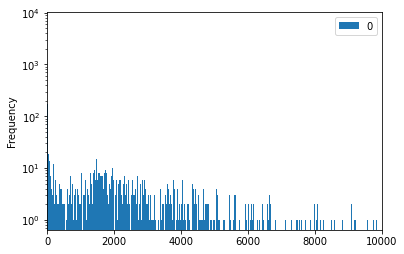

In [ ]:
pd.DataFrame(outlined_y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

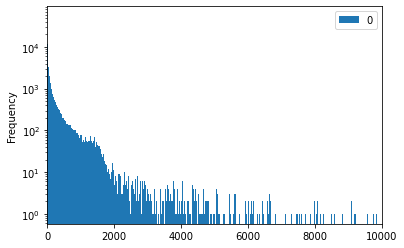

In [ ]:
pd.DataFrame(y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

#### Wpływ danych odstających na wynik PCA //DELETE?


In [ ]:
delete_idices = chauvenet(pca_x)
outlined_PCA_x = pca_x[delete_idices,]
outlined_y = y[delete_idices,]
print("y:")
pd.DataFrame(y).describe()
print("outlined y:")
pd.DataFrame(outlined_y).describe()
print("x:")
pd.DataFrame(pca_x).describe()
print("outlined x:")
type(pd.DataFrame(outlined_PCA_x).describe())

y:
outlined y:
x:
outlined x:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000
mean,18.608114,0.492030,2.064810,0.159284,-0.203590,0.193300,-0.277440,-0.511649,0.123611,-0.061149,0.100278,-0.103493,-0.095504,-0.444144,0.144586,0.061815,0.068814,-0.090450,0.231461,-0.085311,0.084285,-0.094891,0.258847,-0.000135
std,22.961627,5.993704,8.611627,2.860034,7.422029,3.403991,6.140406,5.850577,5.144387,4.435089,4.965240,4.006143,3.199143,4.456152,2.858908,3.685668,3.051106,2.340624,3.265601,2.949113,2.514095,2.519699,2.036818,1.908782
min,-3.082867,-20.566646,-0.786989,-40.015127,-130.710895,-69.910764,-87.608777,-66.805715,-95.739996,-68.837836,-80.505310,-86.015015,-70.679962,-56.051852,-66.616934,-28.374081,-51.366839,-31.988136,-33.137728,-34.338097,-18.145489,-31.055700,-16.369851,-13.528179
25%,5.499707,-1.273431,-0.289613,-0.088968,-0.082905,-0.075999,-0.106720,-2.057423,-0.151397,-0.095717,-0.070986,-0.131953,-0.202499,-2.123426,-0.307228,-1.770618,-0.609954,-0.591287,-1.271791,-1.320067,-1.042481,-1.086568,-0.753428,-0.609016
50%,12.968789,0.022840,0.180126,-0.039543,0.026712,-0.017786,-0.013990,-0.112347,-0.003604,-0.006009,0.008932,-0.003523,0.005794,-0.804013,0.220492,-0.126459,-0.004566,0.060127,0.076292,0.010576,-0.004163,-0.030156,-0.014707,0.001093
75%,23.713386,0.626230,0.954299,0.030626,0.083889,0.074431,0.107799,1.309953,0.156107,0.074536,0.084331,0.129252,0.175637,0.359539,0.705919,1.807027,0.590319,0.556983,1.499138,1.169708,1.120991,0.873334,0.929715,0.565536
max,311.931631,135.216252,242.574907,70.746819,230.432056,74.776214,198.245995,67.037999,119.360356,100.368818,116.702390,88.343674,96.582550,62.744604,80.167409,46.889018,57.958350,34.807324,54.053702,35.020484,48.531361,55.076302,29.464362,42.467010


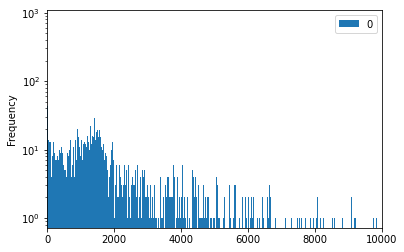

In [ ]:
pd.DataFrame(outlined_y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

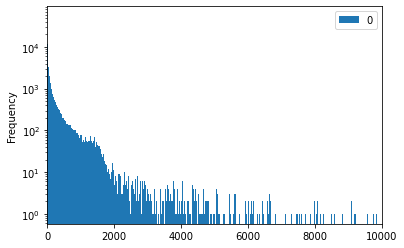

In [ ]:
pd.DataFrame(y).plot.hist(bins=10000,xlim=(0,10000), logy=True)

### Wykres pudełkowy


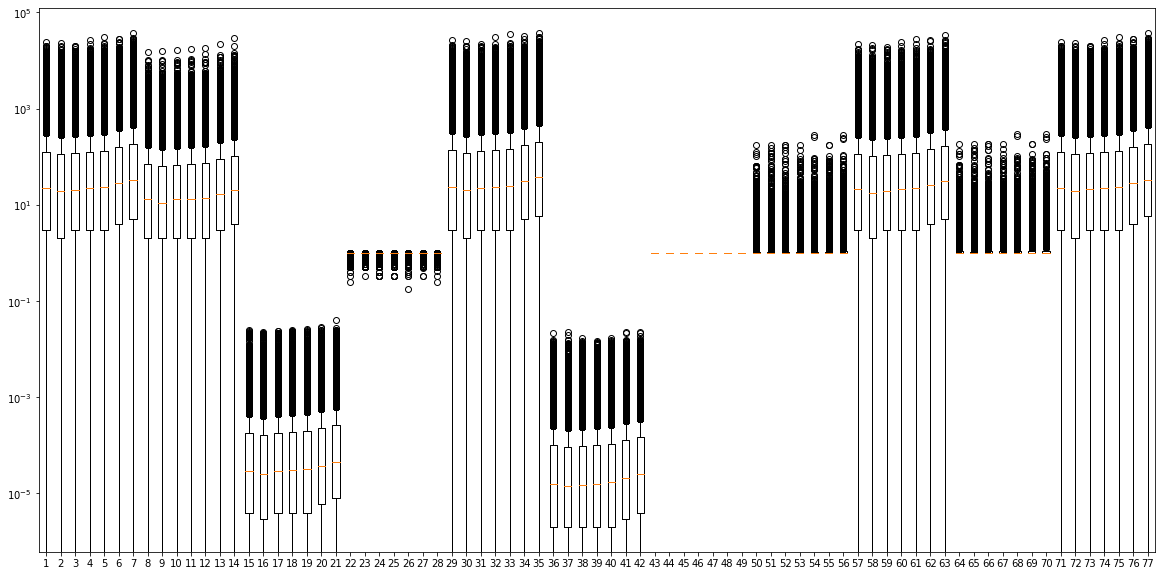

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(20, 10))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(x)
plt.yscale("log")
plt.show()

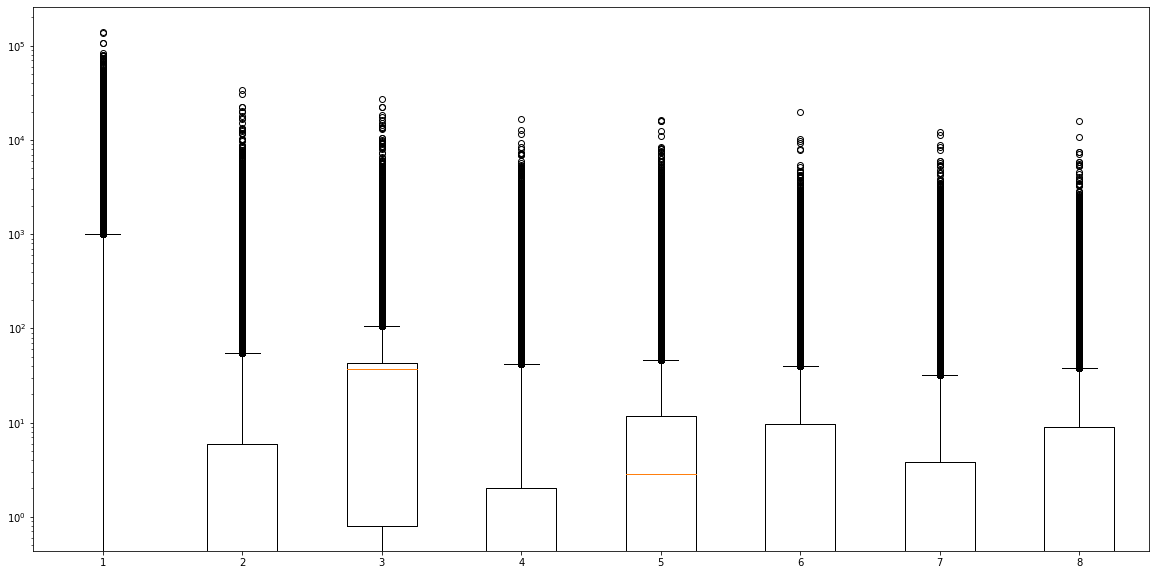

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(20, 10))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(pca_x)
plt.yscale("log")
plt.show()

SVM N/A bo odrzucamy klasyfikację

O-SVM N/A bo odrzucamy klasyfikacje

Las izolacyjny

Wygładzanie danych N/A bo nie mamy obrazu ani seri danych?

Filtry N/A bo nie obraz

# Wykład 4

**Kowariancja** - obliczona dla 11 atrybutów.

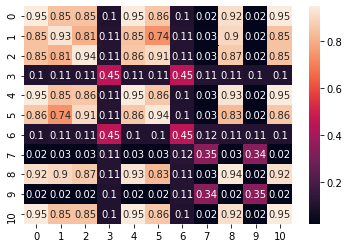

In [ ]:
NCD = x[:, 0:6]  # number of created discussions
NCD_mean = np.mean(NCD, axis=1)

AI = x[:, 7:13]  # author increase
AI_mean = np.mean(AI, axis=1)

AL = x[:, 14:20]  # attention level
AL_mean = np.mean(AL, axis=1)

BL = x[:, 21:27]  # burstiness level
BL_mean = np.mean(BL, axis=1)

NAC = x[:, 28:34]  # number of atomic containers
NAC_mean = np.mean(NAC, axis=1)

AS_NAC = x[:, 35:41]  # attention level (measured with number of contributions)
AS_NAC_mean = np.mean(AS_NAC, axis=1)

CS = x[:, 42:48]  # contribution sparseness
CS_mean = np.mean(CS, axis=1)

AT = x[:, 49:55]  # author interaction
AT_mean = np.mean(AT, axis=1)

NA = x[:, 56:62]  # number of authors
NA_mean = np.mean(NA, axis=1)

ADL = x[:, 63:69]  # average discussion length
ADL_mean = np.mean(ADL, axis=1)

NAD = x[:, 70:76]  # average discussion length (NAD)
NAD_mean = np.mean(NAD, axis=1)

cov_data = np.asarray([NCD_mean, AI_mean, AL_mean, BL_mean, NAC_mean, AS_NAC_mean, CS_mean, AT_mean, NA_mean, ADL_mean, NAD_mean])
covMatrix = np.cov(cov_data, bias=True)
covMatrix = np.round(covMatrix, 2)
sns.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

**Korelacja** - obliczona dla 11 atrybutów.

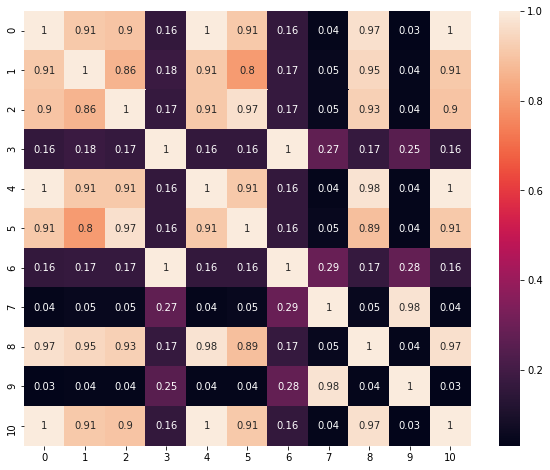

In [ ]:
x = std_x
NCD = x[:, 0:6]  # number of created discussions
NCD_mean = np.mean(NCD, axis=1)

AI = x[:, 7:13]  # author increase
AI_mean = np.mean(AI, axis=1)

AL = x[:, 14:20]  # attention level
AL_mean = np.mean(AL, axis=1)

BL = x[:, 21:27]  # burstiness level
BL_mean = np.mean(BL, axis=1)

NAC = x[:, 28:34]  # number of atomic containers
NAC_mean = np.mean(NAC, axis=1)

AS_NAC = x[:, 35:41]  # attention level (measured with number of contributions)
AS_NAC_mean = np.mean(AS_NAC, axis=1)

CS = x[:, 42:48]  # contribution sparseness
CS_mean = np.mean(CS, axis=1)

AT = x[:, 49:55]  # author interaction
AT_mean = np.mean(AT, axis=1)

NA = x[:, 56:62]  # number of authors
NA_mean = np.mean(NA, axis=1)

ADL = x[:, 63:69]  # average discussion length
ADL_mean = np.mean(ADL, axis=1)

NAD = x[:, 70:76]  # average discussion length (NAD)
NAD_mean = np.mean(NAD, axis=1)

corr_data = np.asarray([NCD_mean, AI_mean, AL_mean, BL_mean, NAC_mean, AS_NAC_mean, CS_mean, AT_mean, NA_mean, ADL_mean, NAD_mean])
corrMatrix = np.corrcoef(corr_data)
corrMatrix = np.round(corrMatrix, 2)
plt.figure(figsize=(10,8))
sns.heatmap(corrMatrix, annot=True, fmt='g')
plt.show()

# Wykład 5

# Dodatkowe modele

In [ ]:
model = create_network_model(std_x,y)
fit_model(model, std_x, y)

Epoch 1/20
15830/15830 [==============================] - 32s 2ms/step - loss: 116512.6368 - val_loss: 99355.5547
Epoch 2/20
15830/15830 [==============================] - 30s 2ms/step - loss: 64762.3564 - val_loss: 51311.6289
Epoch 3/20
15830/15830 [==============================] - 30s 2ms/step - loss: 91415.2075 - val_loss: 36358.8984
Epoch 4/20
15830/15830 [==============================] - 30s 2ms/step - loss: 70017.4797 - val_loss: 33220.0312
Epoch 5/20
15830/15830 [==============================] - 30s 2ms/step - loss: 74737.5418 - val_loss: 33980.1484
Epoch 6/20
15830/15830 [==============================] - 30s 2ms/step - loss: 77929.6062 - val_loss: 33969.1914
Epoch 7/20
15830/15830 [==============================] - 30s 2ms/step - loss: 89363.6871 - val_loss: 76629.7344
Epoch 8/20
15830/15830 [==============================] - 31s 2ms/step - loss: 68900.5705 - val_loss: 29930.7051
Epoch 9/20
15830/15830 [==============================] - 30s 2ms/step - loss: 71527.6163 - val

Ridge regression



In [ ]:
y_pred_ridge, y_test_ridge = create_and_fit_ridge_model(std_x, y)

RMSE: 186.05857423244055
MAE: 62.231679773306084
R^2: 0.8783425152403876


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-2000.0, 2000.0)

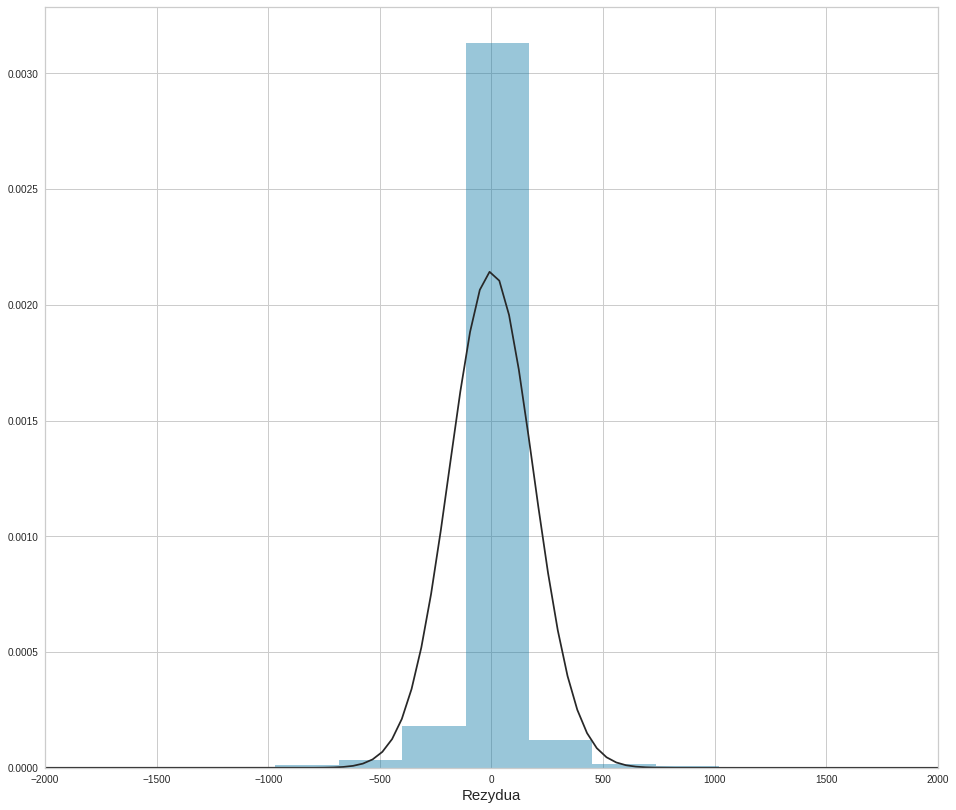

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(std_x, y, test_size=0.1, random_state=512)

# # Create the visualizer, fit, score, and show it
# viz = yellowbrick.regressor.residuals.residuals_plot(Ridge(), X_train, y_train, X_test, y_test)
residuals = y_test_ridge - y_pred_ridge

plt.figure(figsize=(16,14))
sns.distplot(residuals, fit=norm, kde=False, bins=30)
plt.xlabel('Rezydua', fontsize = 15) 
plt.xlim(-2000, 2000)  

# fit = sp.stats.norm.pdf(residuals, np.mean(residuals), np.std(residuals))  #this is a fitting indeed
# plt.plot(residuals,fit,'-o')
# plt.hist(residuals) #,normed=True)      #use this to draw histogram of your data
# plt.show()  

# sns.distplot(residuals, bins = 100) # you may select the no. of bins
# plt.title('Error Terms', fontsize=20)           
# plt.xlabel('Residuals', fontsize = 15) 
# plt.xlim(-2000, 2000)    
# plt.show()

# residuals = sorted(residuals)
# normal_distribution = sp.stats.norm.pdf(residuals, np.mean(residuals), np.std(residuals))
# plt.plot(residuals, normal_distribution)
# plt.hist(residuals)

# plt.show

# plt.hist(residuals)
# plt.xlim(-2000, 2000)
# plt.xlabel('Residuals')
# plt.show

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Rezydua - po transformacji Box-Cox')

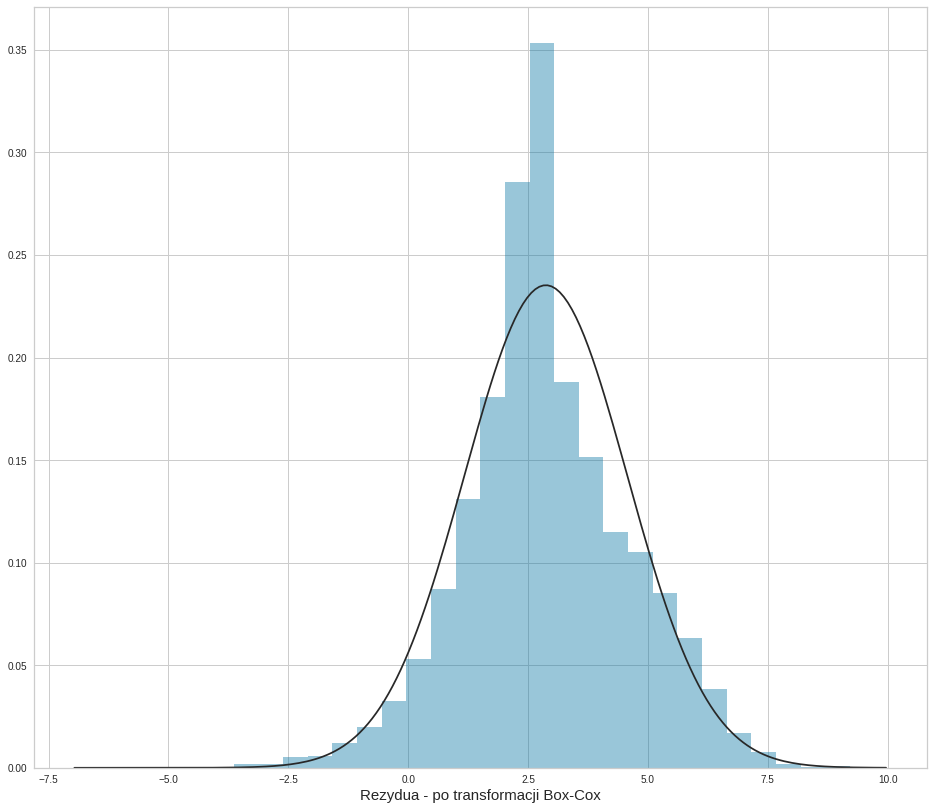

In [ ]:
data = abs(y_pred_ridge - y_test_ridge)

fitted_data, fitted_lambda = sp.stats.boxcox(data) 

plt.figure(figsize=(16,14))
sns.distplot(fitted_data, fit=norm, kde=False, bins=30)
plt.xlabel('Rezydua - po transformacji Box-Cox', fontsize = 15) 

# plt.xlim(-2000, 2000)  

ElasticNet regression

In [ ]:
y_pred_elastic, y_test_elastic = create_and_fit_elasticnet_model(std_x, y)

RMSE: 198.5060444016029
MAE: 63.68089974654969
R^2: 0.8615200408742332


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-2000.0, 2000.0)

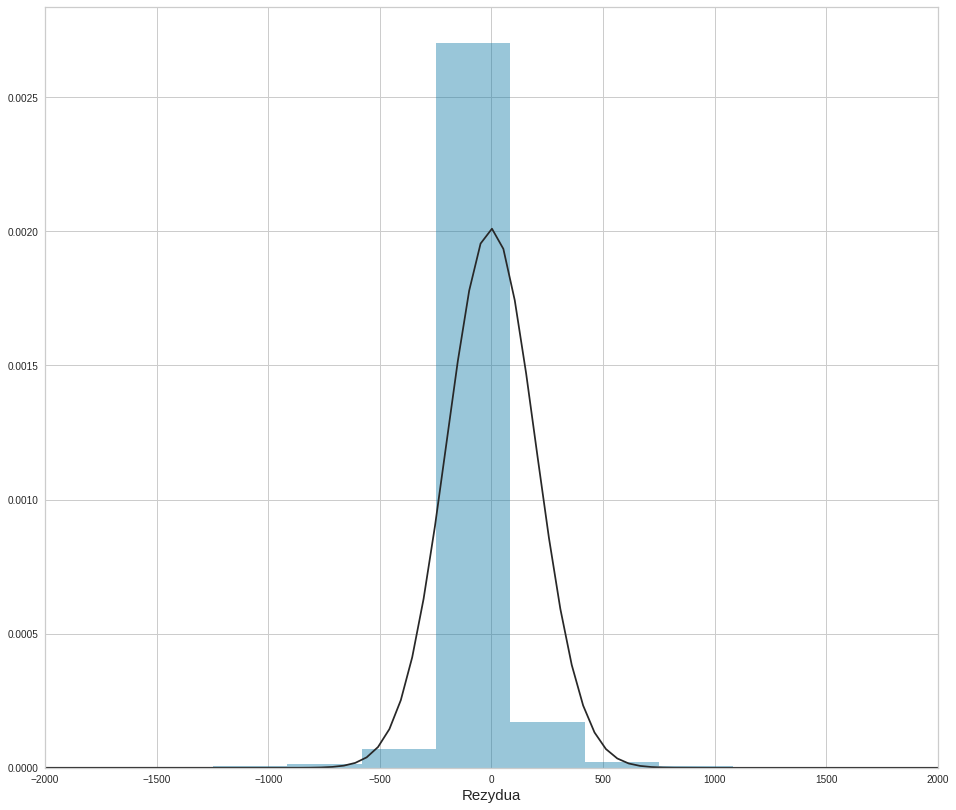

In [ ]:
residuals = y_test_elastic - y_pred_elastic

plt.figure(figsize=(16,14))
sns.distplot(residuals, x=residuals, fit=norm, kde=False, bins=30)
plt.xlabel('Rezydua', fontsize = 15) 
plt.xlim(-2000, 2000) 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Rezydua - po transformacji Box-Cox')

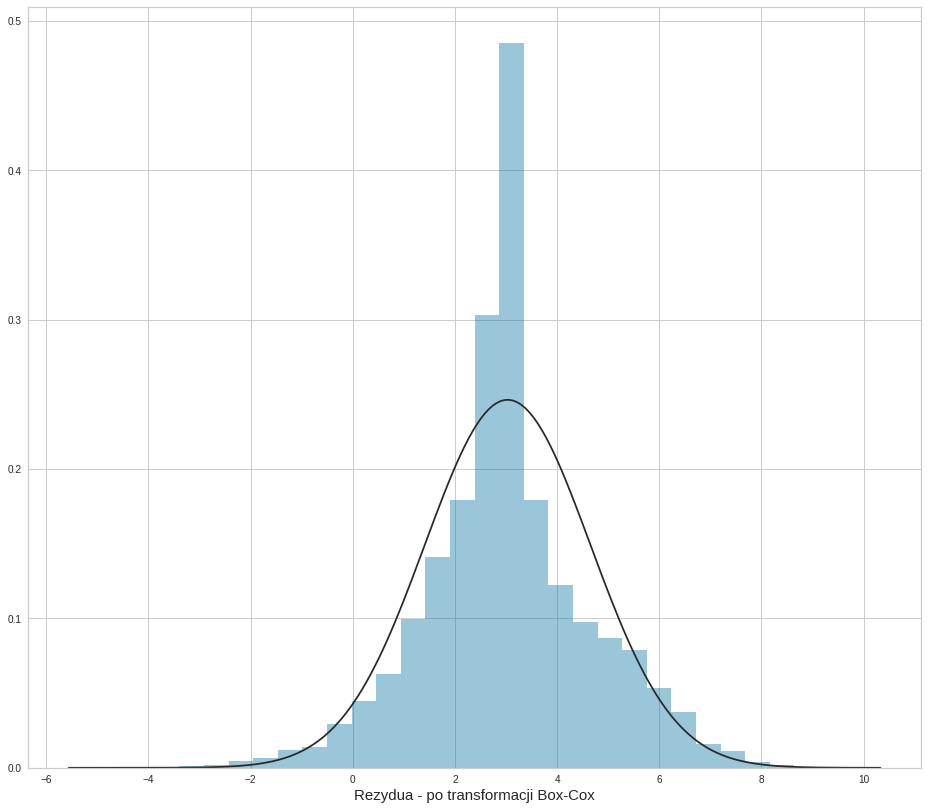

In [ ]:
data = abs(y_pred_elastic - y_test_elastic)

fitted_data, fitted_lambda = sp.stats.boxcox(data) 

plt.figure(figsize=(16,14))
sns.distplot(fitted_data, fit=norm, kde=False, bins=30)
plt.xlabel('Rezydua - po transformacji Box-Cox', fontsize = 15) 

Recurrent Neural Network

In [ ]:
rec_model = create_reccurent_net_model()
fit_recurrent_net_model(rec_model, serialized_x, y)

TypeError: ignored

In [ ]:
for _ in range(10):
  fit_recurrent_net_model(rec_model, serialized_x, y)

XGBoost


In [ ]:
 runs = 10
 res = [[] for _ in range(runs)] 

 
 for i in range(runs):
   res[i] = fit_xgboost_model(std_x, y, learning_rate = i / 20, colsample_bytree = i / 20, max_depth = 10, alpha = 5, n_estimators = 20)

results = np.asarray(res)

print('RMSE; MAE; R^2')
mean = np.mean(results, axis = 0)
min = np.min(results, axis = 0)
max = np.max(results, axis = 0)

print(f'mean values: {mean}')
print(f'min values: {min}')
print(f'max values: {max}')


RMSE; MAE; R^2
mean values: [236.57480674  73.03990255   0.75725705]
min values: [ 1.77044792e+02  5.43602539e+01 -1.25739013e-01]
max values: [565.97745313 189.27833843   0.88984461]


Transformacja Box-Cox - regresja Ridge

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Lambda value used for Transformation: 0.01271832373564288


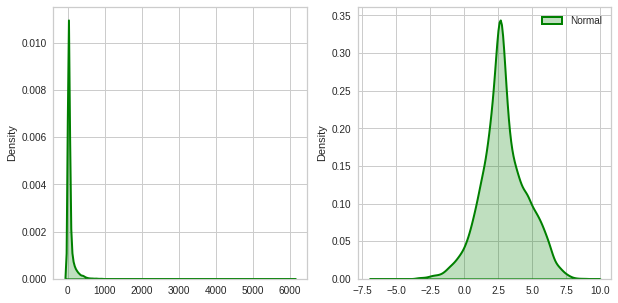

In [ ]:
# data = abs(y_pred_ridge - y_test_ridge)

# fitted_data, fitted_lambda = sp.stats.boxcox(data) 
  
# # creating axes to draw plots 
# fig, ax = plt.subplots(1, 2) 
  
# # plotting the original data(non-normal) and  
# # fitted data (normal) 
# sns.distplot(data, hist = False, kde = True, 
#             kde_kws = {'shade': True, 'linewidth': 2},  
#             label = "Non-Normal", color ="green", ax = ax[0]) 
  
# sns.distplot(fitted_data, hist = False, kde = True, 
#             kde_kws = {'shade': True, 'linewidth': 2},  
#             label = "Normal", color ="green", ax = ax[1]) 
  
# # adding legends to the subplots 
# plt.legend(loc = "upper right") 
  
# # rescaling the subplots 
# fig.set_figheight(5) 
# fig.set_figwidth(10) 
  
# print(f"Lambda value used for Transformation: {fitted_lambda}") 

Transformacja Box-Cox - regresja Elastic Net

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Lambda value used for Transformation: 0.018675164230195555


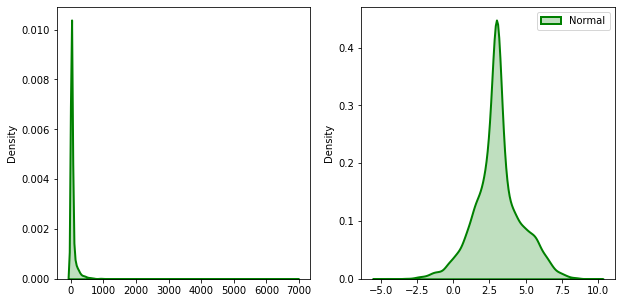

In [ ]:
data = abs(y_pred_elastic - y_test_elastic)

fitted_data, fitted_lambda = sp.stats.boxcox(data) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", color ="green", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="green", ax = ax[1]) 
  
# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
  
print(f"Lambda value used for Transformation: {fitted_lambda}") 